# Детекция лиц с использованием архитектуры MobileNetV2

# 1. Подготовка датасета
В качестве датасета выбран датасет **Widerface** с большим количеством изображений и соотвествующих им координат прямоугольника лиц `(x, y, w, h)`.

## Подготовка аннотаций из датасета
Сначала извлечем аннотации из датасета в формате `(путь_к_изображению, список_координат_лиц_изображения)`. Поскольку датасет большой, а обучать на сильно больших данных не можем ввиду слабого ПК без `GPU`, аннотации для тренировочних данных и для валидации будем брать из папки изображений с тренировочными данными.

In [68]:
from sklearn.model_selection import train_test_split
import cv2

In [69]:
WIDER_FACE_PATH = "C:/Users/PAVILION/Desktop/Coding/Datasets/wider_face/"

In [70]:
all_annotations = []
with open(WIDER_FACE_PATH + "wider_face_split/wider_face_train_bbx_gt.txt", 'r') as f:
    lines = f.readlines()
i = 0
while i < len(lines):
    img_name = lines[i].strip()
    i += 1
    num_boxes = int(lines[i].strip())
    i += 1
    bboxes = []
    for _ in range(num_boxes):
        if i >= len(lines):
            break
        box_data = list(map(int, lines[i].strip().split()[:4]))
        bboxes.append(box_data)
        i += 1
    all_annotations.append((img_name, bboxes))

# Разделение на train/val
train_annots, val_annots = train_test_split(all_annotations, test_size=0.2, random_state=42)

Получаем искомые аннотации

In [71]:
train_annots[0]

('46--Jockey/46_Jockey_Jockey_46_1003.jpg', [[224, 158, 144, 170]])

Реализуем функцию для демонстрации n аннотаций

In [72]:
def demonstrate(annots, n):
    for i in range(n):
        # Загружаем изображение
        image = cv2.imread(WIDER_FACE_PATH + "WIDER_train/images/" + annots[i][0])  # путь к файлу
        
        # Получаем размеры изображения
        height, width = image.shape[:2]
        
        for rect in annots[i][1]:
            # Рисуем прямоугольник (рамку)
            # cv2.rectangle(изображение, (x1, y1), (x2, y2), (B, G, R), толщина)
            x, y, w, h = rect
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)
        
        # Выводим изображение
        cv2.imshow("Image with Frame", image)
        cv2.waitKey(0)  # Ждём нажатия любой клавиши
        cv2.destroyAllWindows()  # Закрываем окно

Поскольку нашей задачей является детекция одного лица на изображении на небольшом, но достоточном наборе данных для обучения, то выберем те аннотации, где есть **только 1 лицо** и размер лица (`w*h`) больше `20000`. 

In [73]:
train_annots_one_face = [i for i in train_annots if len(i[1]) == 1 and i[1][0][2]*i[1][0][3] > 2000]
demonstrate(train_annots_one_face, 10)
len(train_annots_one_face)

3487

In [74]:
val_annots_one_face = [i for i in val_annots if len(i[1]) == 1 and i[1][0][2]*i[1][0][3] > 2000]
demonstrate(val_annots_one_face, 10)
len(val_annots_one_face)

841

Получаем размер тренировочного датасета - `2090` и размер валидационного - `531`, что удовлетворяет нашим требованиям по производительности при обучении.

## Подготовка данных для обучения
Сначала импортируем библиотеки для работы с изображениями.

In [75]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import numpy as np

Чтобы подготовить данные для обучения нейросети, извлечем по отдельности изображения для тренировки и валидации, координаты лиц для изображений и классовую метку о наличие лица на изображении (`train_images`, `train_bboxes`, `train_labels` и  `val_images`, `val_bboxes`, `val_labels`).

1. Загрузим изображение
2. Изменим размер изображения до стандартного (224x224)
3. Нормализуем значения пикселей
4. Нормализуем координаты ограничивающих прямоугольников (из пикселей в относительные значения от 0 до 1).

In [76]:
# Размер изображения для VGG16
IMG_HEIGHT, IMG_WIDTH = 224, 224

In [77]:
def preprocess_data(annotation_list, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    images = []
    bboxes = [] # [x_min, y_min, x_max, y_max] в относительных координатах
    labels = [] # 1 если есть лицо, 0 если нет

    for img_path, annots in annotation_list:
        full_path_to_img = WIDER_FACE_PATH + "WIDER_train/images/" + img_path
        img = load_img(full_path_to_img, target_size=target_size)
        img = img_to_array(img) / 255.0  # Нормализация до [0, 1]
        images.append(img)

        if len(annots) > 0:
            # Берем только первый ограничивающий прямоугольник для простоты
            # В более сложной модели можно использовать якоря или другие методы.
            bbox = annots[0]
            x, y, w, h = bbox

            # Перевод в формат (x_min, y_min, x_max, y_max) и нормализация
            original_width, original_height = Image.open(full_path_to_img).size
            
            # Координаты x_min, y_min, x_max, y_max относительно исходного размера
            x_min_abs = x
            y_min_abs = y
            x_max_abs = x + w
            y_max_abs = y + h

            # Нормализация к [0, 1] относительно целевого размера (224x224)
            # Важно: При изменении размера изображения, координаты BBox также масштабируются
            # Это упрощенный подход. Для более точного масштабирования нужно учитывать аспекты.
            # Здесь мы просто масштабируем относительно целевого размера.
            norm_x_min = x_min_abs / original_width
            norm_y_min = y_min_abs / original_height
            norm_x_max = x_max_abs / original_width
            norm_y_max = y_max_abs / original_height
            
            bboxes.append([norm_x_min, norm_y_min, norm_x_max, norm_y_max])
            labels.append(1) # Присутствует лицо
        else:
            # Если лиц нет, устанавливаем bbox в [0,0,0,0] и label 0
            bboxes.append([0.0, 0.0, 0.0, 0.0])
            labels.append(0) # Лицо отсутствует

    return np.array(images), np.array(bboxes), np.array(labels)

In [101]:
print("Обработка тренировочных данных...")
train_images, train_bboxes, train_labels = preprocess_data(train_annots_one_face)

print(f"Размер тренировочных изображений: {train_images.shape}")
print(f"Размер тренировочных bbox: {train_bboxes.shape}")
print(f"Размер тренировочных меток: {train_labels.shape}")

Обработка тренировочных данных...
Размер тренировочных изображений: (3487, 224, 224, 3)
Размер тренировочных bbox: (3487, 4)
Размер тренировочных меток: (3487,)


In [102]:
print("Обработка валидационных данных...")
val_images, val_bboxes, val_labels = preprocess_data(val_annots_one_face)

print(f"Размер валидационных изображений: {val_images.shape}")

Обработка валидационных данных...
Размер валидационных изображений: (841, 224, 224, 3)


## Аугментация данных
Даже для большого датасета требуется аугментация, так как даже в таком объекты детекции могут быть "неудобно" расположены для обучения модели, что отразится на ее качестве

In [80]:
import tensorflow as tf

Функции для аугментации

In [104]:
def augment_image_and_bbox(image, bbox):
    image, bbox = random_flip(image, bbox)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image, bbox = random_zoom(image, bbox, zoom_range=(0.9, 1.1))
    image, bbox = random_shift(image, bbox, max_shift=0.1)
    return image, bbox

def random_flip(image, bbox):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        x1, y1, x2, y2 = tf.unstack(bbox)
        bbox = tf.stack([1.0 - x2, y1, 1.0 - x1, y2])
    return image, bbox

def random_zoom(image, bbox, zoom_range=(0.9, 1.1)):
    h, w, _ = image.shape
    zoom = tf.random.uniform((), *zoom_range)
    new_h = tf.cast(h * zoom, tf.int32)
    new_w = tf.cast(w * zoom, tf.int32)

    image = tf.image.resize(image, (new_h, new_w))
    image = tf.image.resize_with_crop_or_pad(image, h, w)
    return image, bbox

def random_shift(image, bbox, max_shift=0.2):
    # Если вход — tf.Tensor, преобразуем в numpy
    try:
        import tensorflow as tf
        if isinstance(image, tf.Tensor):
            image = image.numpy()
    except ImportError:
        pass  # tensorflow может не быть

    # Проверка типа
    if not isinstance(image, np.ndarray):
        raise ValueError(f"image должен быть numpy.ndarray, а не {type(image)}")

    h, w = image.shape[:2]

    max_dx = int(w * max_shift)
    max_dy = int(h * max_shift)
    dx = np.random.randint(-max_dx, max_dx + 1)
    dy = np.random.randint(-max_dy, max_dy + 1)

    M = np.float32([[1, 0, dx], [0, 1, dy]])
    shifted_img = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT101)

    x1, y1, x2, y2 = bbox
    x1_pix, y1_pix = int(x1 * w), int(y1 * h)
    x2_pix, y2_pix = int(x2 * w), int(y2 * h)

    x1_pix += dx
    y1_pix += dy
    x2_pix += dx
    y2_pix += dy

    x1_pix = np.clip(x1_pix, 0, w - 1)
    y1_pix = np.clip(y1_pix, 0, h - 1)
    x2_pix = np.clip(x2_pix, 0, w - 1)
    y2_pix = np.clip(y2_pix, 0, h - 1)

    new_bbox = [x1_pix / w, y1_pix / h, x2_pix / w, y2_pix / h]

    return shifted_img, new_bbox

In [105]:
def apply_augmentations(images, bboxes, labels):
    augmented_images = []
    augmented_bboxes = []
    augmented_labels = []

    for img, bbox, label in zip(images, bboxes, labels):
        # Преобразуем в тензоры
        img = tf.convert_to_tensor(img, dtype=tf.float32)
        bbox = tf.convert_to_tensor(bbox, dtype=tf.float32)

        # Аугментации
        img = tf.image.convert_image_dtype(img, tf.float32)  # если в [0, 255]
        img, bbox = augment_image_and_bbox(img, bbox)

        # Возврат в numpy
        augmented_images.append(img)
        augmented_bboxes.append(bbox)
        augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_bboxes), np.array(augmented_labels)

In [106]:
train_images, train_bboxes, train_labels = apply_augmentations(
    train_images, train_bboxes, train_labels
)

val_images, val_bboxes, val_labels = apply_augmentations(
    val_images, val_bboxes, val_labels
)

In [107]:
print(f"Размер тренировочных изображений: {train_images.shape}")
print(f"Размер тренировочных bbox: {train_bboxes.shape}")
print(f"Размер тренировочных меток: {train_labels.shape}")
print(f"Размер валидационных изображений: {val_images.shape}")

Размер тренировочных изображений: (3487, 224, 224, 3)
Размер тренировочных bbox: (3487, 4)
Размер тренировочных меток: (3487,)
Размер валидационных изображений: (841, 224, 224, 3)


In [108]:
def show_images_with_bboxes_opencv(images, bboxes, labels=None, num=5):
    for i in range(num):
        img = images[i].copy()  # копируем, чтобы не изменять исходное
        bbox = bboxes[i]
        
        h, w = img.shape[:2]
        x1, y1, x2, y2 = bbox
        # преобразуем нормализованные координаты в пиксели
        pt1 = (int(x1 * w), int(y1 * h))
        pt2 = (int(x2 * w), int(y2 * h))
        
        # Преобразуем изображение из float32 (0..1) в uint8 (0..255)
        img_show = (img * 255).astype(np.uint8)
        img_show = cv2.cvtColor(img_show, cv2.COLOR_RGB2BGR)  # RGB -> BGR для OpenCV
        
        # Рисуем прямоугольник
        cv2.rectangle(img_show, pt1, pt2, color=(0, 0, 255), thickness=2)
        
        # Если есть метки, выводим их на изображение
        if labels is not None:
            label = str(labels[i])
            cv2.putText(img_show, label, (pt1[0], pt1[1]-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        
        # Показываем изображение в окне
        cv2.imshow(f'Image {i+1}', img_show)
        cv2.waitKey(0)  # ждем нажатия любой клавиши
        cv2.destroyAllWindows()

In [109]:
show_images_with_bboxes_opencv(train_images, train_bboxes, train_labels, num=10)

# 2. Проектирование и обучение модели
Для построение модели будем использовать архитектуру MobileNetV2, но MobileNetV2 - это классификационная модель. Ее можно использовать как основу для создания модели детекции, используя ее как экстрактор признаков.
Ход  построения модели:
1. Извлечение признаков: использовать предобученную MobileNetV2 как экстрактор признаков.
2. Сверточная голова: будет использоваться SSD-подобная голова (Single Shot Detector), которая ключает несколько сверточных слоев, предсказывающие ограничивающие рамки на разных масштабах и соотношениях сторон (якорные боксы).

В сверточной голове реализуем предсказание 4-х координат одного лица и вероятность наличия лица.

## Создание модели

In [110]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

In [116]:
# Загружаем MobileNetV2 без классификационной головы
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [117]:
def create_face_detection_model(base_model, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Ветка для координат bounding box (x_min, y_min, x_max, y_max)
    bbox_output = layers.Dense(4, activation='sigmoid', name='bbox')(x)

    # Ветка для классификации объекта (лицо/не лицо)
    class_output = layers.Dense(1, activation='sigmoid', name='class')(x)

    model = models.Model(inputs=inputs, outputs=[bbox_output, class_output])
    return model

In [119]:
# Создаем модель
model = create_face_detection_model(base_model)

## Обучение. Исследуем стратегию заморозки весов вначале и разморозки в конце

### Этап обучения с заморозкой

In [120]:
# Заморозить весь base_model
base_model.trainable = False

# Компилировать и обучить
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={'bbox': 'mse', 'class': 'binary_crossentropy'},
    metrics={'bbox': 'mae', 'class': 'accuracy'}
)

# Обучаем первые 5 эпох
history = model.fit(
    train_images,
    {'bbox': train_bboxes, 'class': train_labels},
    validation_data=(val_images, {'bbox': val_bboxes, 'class': val_labels}),
    epochs=5,
    batch_size=8
)

Epoch 1/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 111s 238ms/step - bbox_loss: 0.0561 - bbox_mae: 0.1849 - class_accuracy: 1.0000 - class_loss: 0.0080 - loss: 0.0641 - val_bbox_loss: 0.0258 - val_bbox_mae: 0.1223 - val_class_accuracy: 1.0000 - val_class_loss: 0.0014 - val_loss: 0.0273
Epoch 2/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 94s 215ms/step - bbox_loss: 0.0302 - bbox_mae: 0.1356 - class_accuracy: 1.0000 - class_loss: 0.0014 - loss: 0.0316 - val_bbox_loss: 0.0228 - val_bbox_mae: 0.1144 - val_class_accuracy: 1.0000 - val_class_loss: 8.0451e-04 - val_loss: 0.0237
Epoch 3/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 94s 216ms/step - bbox_loss: 0.0249 - bbox_mae: 0.1221 - class_accuracy: 1.0000 - class_loss: 0.0011 - loss: 0.0259 - val_bbox_loss: 0.0208 - val_bbox_mae: 0.1099 - val_class_accuracy: 1.0000 - val_class_loss: 4.5923e-04 - val_loss: 0.0214
Epoch 4/5
436/436 ━━━━━━━━━━━━━━━━━━━━ 108s 248ms/step - bbox_loss: 0.0210 - bbox_mae: 0.1129 - class_accuracy: 1.0000 - class_loss: 7.3010e-04 - loss: 0.0217 - val_bbox

### Этап обучения без заморозки

In [121]:
# Разморозить последние 30 слоёв MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Компилировать заново с меньшим learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # меньше lr!
    loss={'bbox': 'mse', 'class': 'binary_crossentropy'},
    metrics={'bbox': 'mae', 'class': 'accuracy'}
)

# Обучаем дальше еще 10 эпох
model.fit(
    train_images,
    {'bbox': train_bboxes, 'class': train_labels},
    validation_data=(val_images, {'bbox': val_bboxes, 'class': val_labels}),
    epochs=10,
    batch_size=8
)

Epoch 1/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 144s 294ms/step - bbox_loss: 0.0223 - bbox_mae: 0.1167 - class_accuracy: 1.0000 - class_loss: 8.5024e-04 - loss: 0.0232 - val_bbox_loss: 0.0207 - val_bbox_mae: 0.1099 - val_class_accuracy: 1.0000 - val_class_loss: 7.8151e-05 - val_loss: 0.0209
Epoch 2/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 116s 267ms/step - bbox_loss: 0.0198 - bbox_mae: 0.1093 - class_accuracy: 1.0000 - class_loss: 4.3389e-04 - loss: 0.0203 - val_bbox_loss: 0.0197 - val_bbox_mae: 0.1066 - val_class_accuracy: 1.0000 - val_class_loss: 8.4828e-05 - val_loss: 0.0199
Epoch 3/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 126s 288ms/step - bbox_loss: 0.0185 - bbox_mae: 0.1054 - class_accuracy: 1.0000 - class_loss: 4.6710e-04 - loss: 0.0190 - val_bbox_loss: 0.0192 - val_bbox_mae: 0.1047 - val_class_accuracy: 1.0000 - val_class_loss: 6.7018e-05 - val_loss: 0.0194
Epoch 4/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 117s 268ms/step - bbox_loss: 0.0175 - bbox_mae: 0.1023 - class_accuracy: 1.0000 - class_loss: 3.6372e-04 - l

## Сохраним модель

In [122]:
import os
base_save_dir = r"C:\Users\PAVILION\Desktop\Coding\TrainedModels"
model_save_path_keras = os.path.join(base_save_dir, "face_detection_model_3_augmented_trainable_true.keras")

try:
    # Сохранение модели в новом формате .keras
    model.save(model_save_path_keras)
    print(f"Модель успешно сохранена в: {model_save_path_keras}")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

Модель успешно сохранена в: C:\Users\PAVILION\Desktop\Coding\TrainedModels\face_detection_model_3_augmented_trainable_true.keras


# 3. Оценка качества модели

Для оценки качества модели построим график потерь (`loss`) и точности (`accuracy`) для обучающего и валидационного наборов данных. Это поможет нам понять, есть ли переобучение или недообучение.

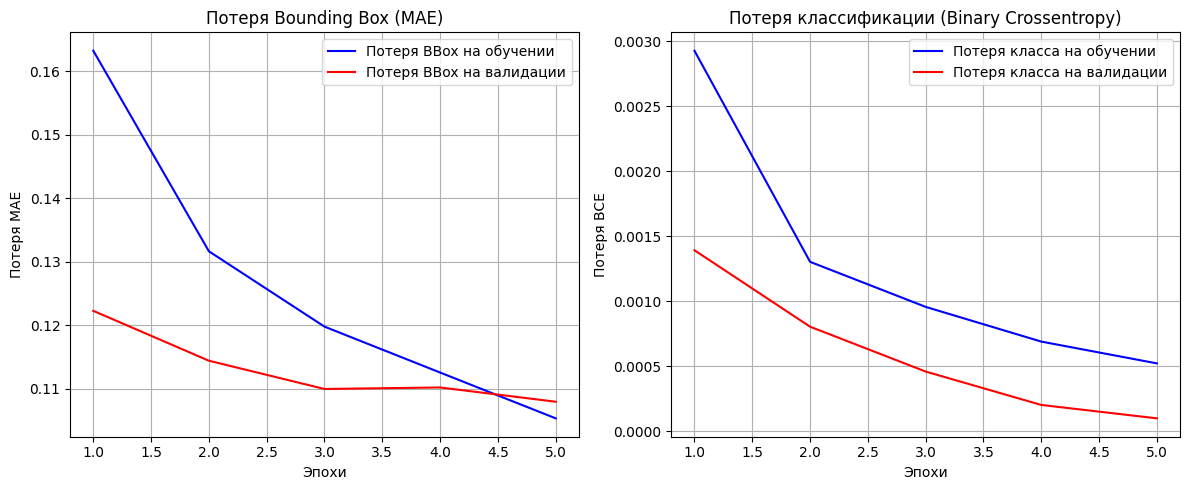

In [123]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Получаем данные из объекта history
    # Потери для bounding box и классификации
    bbox_loss = history.history['bbox_mae']
    val_bbox_loss = history.history['val_bbox_mae']
    class_loss = history.history['class_loss']
    val_class_loss = history.history['val_class_loss']

    total_loss = history.history['loss']

    epochs = range(1, len(total_loss) + 1)

    # График потерь для Bounding Box (MAE)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, bbox_loss, 'b', label='Потеря BBox на обучении')
    plt.plot(epochs, val_bbox_loss, 'r', label='Потеря BBox на валидации')
    plt.title('Потеря Bounding Box (MAE)')
    plt.xlabel('Эпохи')
    plt.ylabel('Потеря MAE')
    plt.legend()
    plt.grid(True)
    
    # График потерь для классификации (Binary Crossentropy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, class_loss, 'b', label='Потеря класса на обучении')
    plt.plot(epochs, val_class_loss, 'r', label='Потеря класса на валидации')
    plt.title('Потеря классификации (Binary Crossentropy)')
    plt.xlabel('Эпохи')
    plt.ylabel('Потеря BCE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Вызов функции для построения графиков
plot_training_history(history)

Как видим, модель **идеально справляется с задачей классификации**, что неудивительно, ведь почти на всех картинках лица есть, а отсутствие лиц - редкость. 
**Предсказание координат рамки лица оказалось переобученным**, так как потеря на валидационных данных остановилась примерно на 3 эпохе в то время как потреря на обучающей выборке стремилась к 0 почти все эпохи.

## Проверка работы модели в реальном времени

In [124]:
# Захват с веб-камеры
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    orig_h, orig_w = frame.shape[:2]

    # Предобработка для модели
    resized = cv2.resize(frame, (224, 224))
    input_tensor = resized.astype('float32') / 255.0
    input_tensor = np.expand_dims(input_tensor, axis=0)  # (1, 224, 224, 3)

    # Предсказание
    bbox_pred, class_pred = model.predict(input_tensor)

    # Первый элемент, так как batch = 1
    bbox_pred = bbox_pred[0]  # (4,)
    class_pred = class_pred[0][0]  # scalar
    
    # Проверка порога
    if class_pred > 0.5:
        x1, y1, x2, y2 = bbox_pred
        x1 = int(x1 * orig_w)
        y1 = int(y1 * orig_h)
        x2 = int(x2 * orig_w)
        y2 = int(y2 * orig_h)
    
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Отображение окна
    cv2.imshow('Face Detection', frame)

    # Выход по клавише 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождение ресурсов
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━

In [39]:
cap = cv2.VideoCapture(0)

# Освобождение ресурсов
cap.release()
cv2.destroyAllWindows()

In [134]:
def show_predictions_on_images(model, images, true_bboxes=None, labels=None, num=5, image_size=(224, 224)):
    """
    Показывает изображения с предсказанными bbox от модели и, опционально, реальными bbox и метками.
    """
    for i in range(num):
        img = images[i]
        input_img = np.expand_dims(img, axis=0)

        # Предсказание модели (ожидаем [bbox, class])
        pred = model.predict(input_img, verbose=0)
        if isinstance(pred, list) and len(pred) == 2:
            pred_bbox = pred[0][0]  # Извлекаем bbox предсказание (1D массив длины 4)
        else:
            pred_bbox = pred[0]  # Если только bbox — используем как есть

        pred_bbox = np.squeeze(pred_bbox)  # Убираем лишние размерности

        # Подготовка изображения для отображения
        img_disp = (img * 255).astype(np.uint8)
        img_disp = cv2.cvtColor(img_disp, cv2.COLOR_RGB2BGR)

        h, w = image_size

        # Преобразуем нормализованные координаты в пиксели
        x1_pred = int(pred_bbox[0] * w)
        y1_pred = int(pred_bbox[1] * h)
        x2_pred = int(pred_bbox[2] * w)
        y2_pred = int(pred_bbox[3] * h)

        # Рисуем предсказанный bbox (красный)
        cv2.rectangle(img_disp, (x1_pred, y1_pred), (x2_pred, y2_pred), (0, 0, 255), 2)

        # Реальный bbox (зелёный)
        if true_bboxes is not None:
            x1_true = int(true_bboxes[i][0] * w)
            y1_true = int(true_bboxes[i][1] * h)
            x2_true = int(true_bboxes[i][2] * w)
            y2_true = int(true_bboxes[i][3] * h)
            cv2.rectangle(img_disp, (x1_true, y1_true), (x2_true, y2_true), (0, 255, 0), 2)

        # Метка класса (если есть)
        if labels is not None:
            label = str(labels[i])
            cv2.putText(img_disp, f'Label: {label}', (10, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

        # Показываем изображение
        cv2.imshow(f'Prediction {i+1}', img_disp)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [136]:
show_predictions_on_images(model, train_images, train_bboxes, train_labels, num=10, image_size=(224, 224))

Сделаем так, чтобы наша модель принимала изображение с камеры ноутбука и распознавала лицо

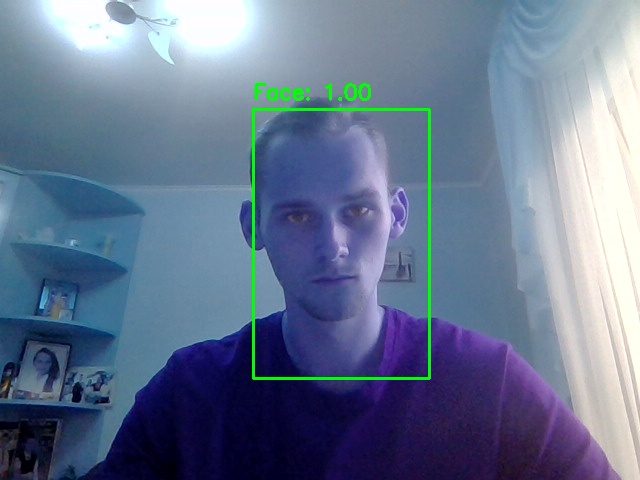

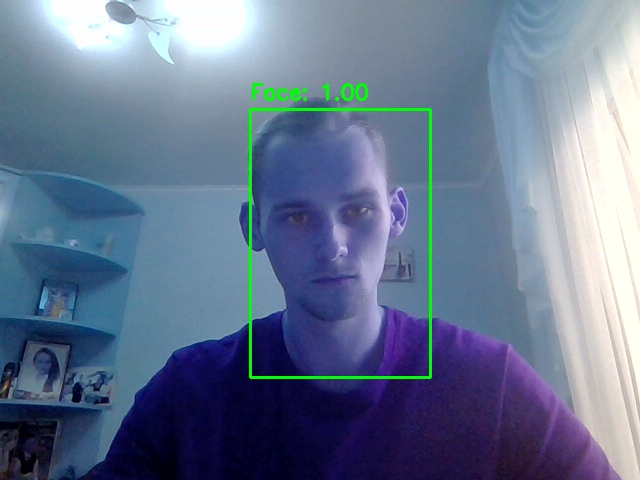

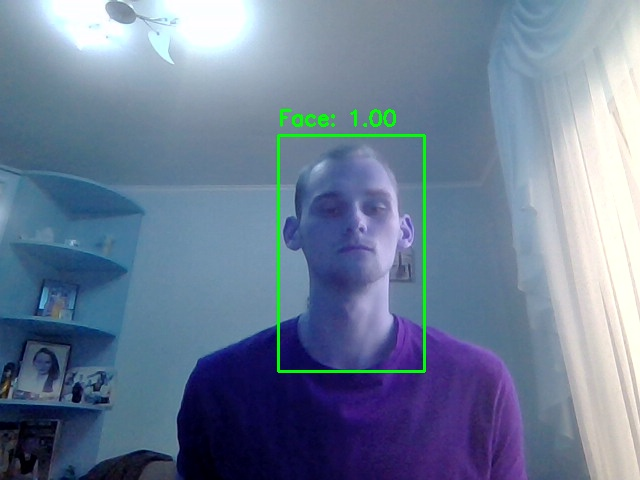

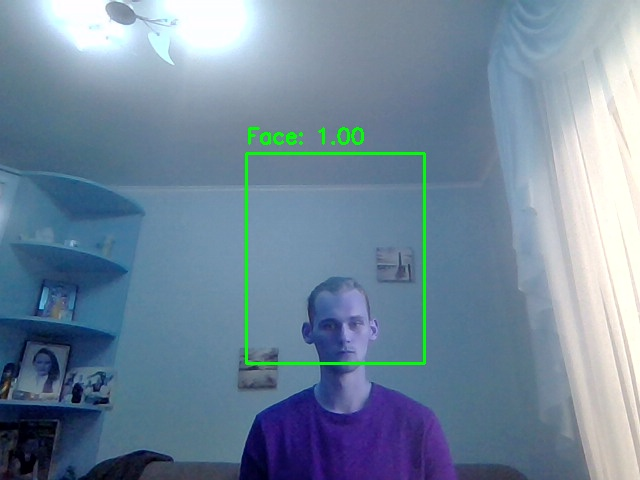

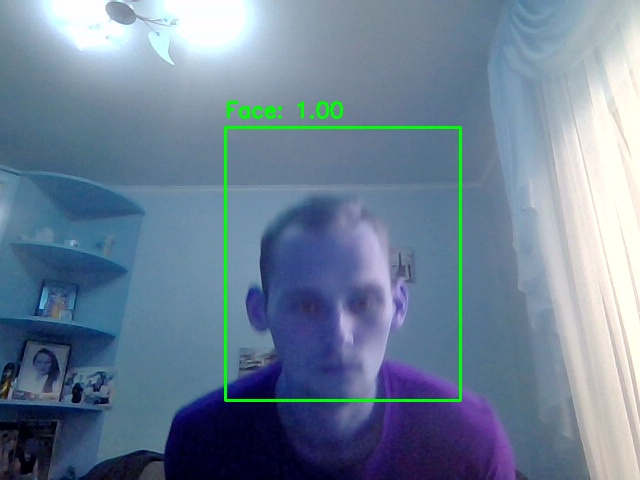

Real time проверка модели завершена.


KeyboardInterrupt: 

In [120]:
import time
from IPython.display import display, Image

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Ошибка: Не удалось открыть веб-камеру.")

last_frame_time = time.time()

frame_count = 0

try:
    while True:
        ret, frame = cap.read()

        if not ret:
            print("Ошибка: Не удалось получить кадр.")
            break

        current_time = time.time()

        if (current_time - last_frame_time) >= 3:
            last_frame_time = current_time
            frame_count += 1

            display_frame = frame.copy()
            original_height, original_width = frame.shape[:2]

            resized_frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
            input_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            input_frame = np.expand_dims(input_frame, axis=0)

            (bbox_pred, class_pred) = model.predict(input_frame, verbose=0)

            norm_x_min, norm_y_min, norm_x_max, norm_y_max = bbox_pred[0]
            face_probability = class_pred[0][0]

            if face_probability > 0.5:
                x_min = int(norm_x_min * original_width)
                y_min = int(norm_y_min * original_height)
                x_max = int(norm_x_max * original_width)
                y_max = int(norm_y_max * original_height)

                cv2.rectangle(display_frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2) # Зеленый
                text = f"Face: {face_probability:.2f}"
                cv2.putText(display_frame, text, (x_min, y_min - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                
                _, encoded_image = cv2.imencode('.jpeg', cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB))
                display(Image(data=encoded_image.tobytes()))
                
except Exception as e:
    print(f"Ошибка: {e}")
finally:
    cap.release()
    print("Real time проверка модели завершена.")

Работа завершена, модель находит координаты лица не совсем точно, но находит. В будущем можно улучшить данную модель, решив проблему с переобучением, сделать распознавание многих лиц.